<a href="https://colab.research.google.com/github/vmendesmagalhaes/machine-learning/blob/main/Moisture_content_on_wood_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variation of moisture content on wood prediction

**Author:** Vitor Mendes Magalhaes

**Email:** vitor.mendes.magalhaes@gmail.com

**Last review:** Fev/2023

Wood is the raw material for many manufactured goods. Charcoal, cellulose for the paper industry, laminated wood furniture, and even explosive products, such as gunpowder cotton, are possible destinations for the wood. On the other hand, the growing use of wood as a raw material has increased illegal deforestation and, as a direct consequence, it has changed the climate at a global level.

Regardless of the destination that will be given to the wood logs, many products that have wood as raw material go through the same stage: the storage of logs in piles.

![](https://drive.google.com/uc?export=view&id=1cvJZKoJ-6OyJ74RzLriWSX6rShB2wi5N)

But as the storage time on piles passes, the moisture content on wood will reduce.

The use of wood in production processes must be optimized to mitigate these adverse effects. One of the determining factors for this optimization is moisture content on wood, i.e., the ratio between the mass of water contained in the wood and dry wood mass.

Here, we develop a Artificial Intelligence-based model - specifically using machine learning classification and regression methods - to predict the moisture content on wood, contributing to a better use of the wood in industry.

Let's start by loading the necessary libraries for solving the present applied research problem.

In [1]:
import pandas as pandas
import numpy as numpy
from numpy import absolute
from numpy import std
from numpy import mean
import matplotlib.pyplot as matplot
import seaborn as seaborn
from sklearn.model_selection import train_test_split as createDataPartition
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as TensorFlow

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import Lasso
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

The next step is importing the spreadsheet (.XLS file) containing the data.

In [2]:
dados = pandas.read_excel('datasetjan23.xls')

Now we have the data, let's start working on it.

First, let's create a new attribute, called *PERCENTUAL*. It means the percentage of weight loss in relation to the total amount of incoming wood logs in each pile.

In [3]:
dados['PERCENTUAL'] = (dados['ESTORNO'] * 100) / dados['TOT_ENTR']

After creating the new attribute, we will remove the instances of piles that didn't have log outputs (in theory, if they do not represent an operational error, these piles continued to receive loads of wood, or were not yet closed, at the time of data capture).

We will also remove instances of piles that have not had reversed charges, that is, that in theory there was no loss of moisture. In the case of wood logs stored outdoors (technically, it is called "natural drying"), under the conditions of the captured data, there will always be moisture loss.

In [4]:
dados.drop(dados[dados['TOT_SAID'] == 0].index, inplace=True)
dados.drop(dados[dados['ESTORNO'] == 0].index, inplace=True)

After removing the instances, let's create copies of the original dataset, which will be used to train different problem solving models using supervised learning: classification models (for different classes) and regression models.

In [5]:
dfClassificacao = dados
dfRegressao = dados

Now, let's start the pre-processing step, removing the attributes that are not interesting for creating the learning models to be applied.

Once this is done, we will continue pre-processing the data, now with a selection of features, removing attributes and biasing the data to conform to the type of supervised learning they propose.

To create the regression model, we will remove the stack identification (*PILHA*), the total outputs (*TOT_SAID*), the difference between the input and output (*DIFERENCA*), the dates (*DATA_INICIO* and *DATA_FIM*) and the amount reversed (*ESTORNO*).

Thus, we make it clear that the class we want to predict is the *PERCENTUAL* of weight loss relative to the total wood input in the pile.

In [6]:
dfRegressao = dfRegressao.drop(["PILHA", "TOT_SAID", "DIFERENCA", "DATA_INICIO", "DATA_FIM", "ESTORNO"], axis=1)

For the creation of classification models, let's create a new attribute, called *INTERVALOPERDA*. Loss ranges are nothing more than weight loss percentage ranges, eg between 0% and 5% loss; between 5% and 10% loss, and so on, as far as the data allows.

To define the best weight loss percentage ranges, we will first analyze visually, using three different visual analysis tools: a *boxplot*, a summary of the *PERCENTUAL* attribute (which will dictate the ranges), and a histogram with the frequency of instances with different percentages.

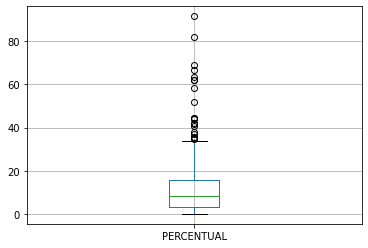

In [7]:
dfClassificacao.boxplot(column =['PERCENTUAL'], grid = True)

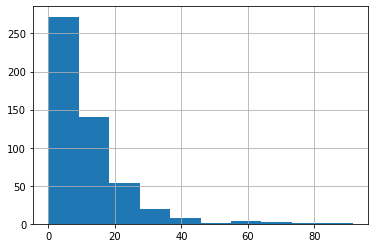

In [8]:
dfClassificacao['PERCENTUAL'].hist()

In [9]:
dfClassificacao.describe()

,PILHA,COMPRIMENTO,TEMP_MIN,TEMP_MAX,TEMP_MED,TEMP_PO,PRECIPITACAO,PATM_MED,UR_MIN,UR_MED,VENTO_MED,RAJ_MAX_MED,QTD_DIAS,TOT_ENTR,TOT_SAID,DIFERENCA,ESTORNO,PERCENTUAL
count,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,5.020000e+02,5.020000e+02,5.020000e+02,5.020000e+02,502.000000
mean,380.834661,5.191633,6.353386,30.933068,17.668108,13.021813,230.048207,1015.596673,29.844622,75.807032,3.020159,10.148426,82.864542,2.955402e+05,2.608087e+05,3.473146e+04,3.217752e+04,11.404791
std,201.004887,0.380277,4.468436,6.301451,3.514570,2.811104,204.907322,2.839966,9.870406,4.102414,0.423014,1.044224,70.283867,4.209043e+05,3.530809e+05,8.307838e+04,7.519074e+04,11.723297
min,1.000000,3.900000,1.900000,18.100000,11.640000,6.380000,0.000000,1005.890000,21.000000,64.360000,1.430000,5.700000,0.000000,1.144000e+04,3.030000e+03,-1.996000e+04,2.000000e+01,0.005657
25%,209.250000,5.200000,3.300000,26.700000,14.965000,11.017500,41.400000,1013.885000,21.000000,71.902500,2.700000,9.480000,22.000000,1.312050e+05,1.127950e+05,6.310000e+03,6.310000e+03,3.414372
50%,381.500000,5.200000,5.400000,32.500000,17.395000,12.805000,184.300000,1016.310000,26.000000,76.105000,3.155000,10.440000,69.000000,2.329100e+05,2.047900e+05,1.883000e+04,1.746000e+04,8.179170
75%,556.750000,5.200000,8.600000,34.400000,20.377500,14.797500,392.200000,1016.920000,36.000000,79.260000,3.260000,10.660000,133.750000,3.658750e+05,3.268445e+05,3.958000e+04,3.842550e+04,15.792322
max,722.000000,6.000000,24.000000,39.400000,26.930000,23.340000,1156.000000,1026.700000,70.000000,84.670000,4.630000,14.300000,425.000000,8.128820e+06,6.628260e+06,1.500560e+06,1.500560e+06,91.583333


In a brief analysis, it is noticed that there are possible operational errors that can generate noise in the classification model, allowing them to be considered outliers.

A clear example is the loss percentage. There are percentages that tend to 100%, which does not occur in this process; there are also percentages that tend to 0% - same situation.

So let's remove the instances with losses above 40%.

In [10]:
dfClassificacao = dfClassificacao.drop(dfClassificacao[dados['PERCENTUAL'] >= 40].index)

Afterwards, let's check again through the *boxplot*.

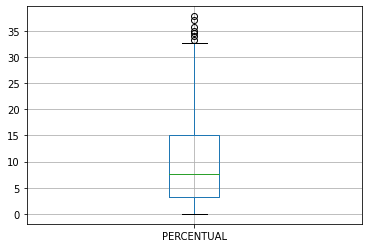

In [11]:
dfClassificacao.boxplot(column =['PERCENTUAL'], grid = True)

Now we can return to the creation of the attribute *INTERVALOPERDA*, establishing different intervals of loss percentages:

CLASS | INTERVAL
--- | ---
1 | less than 10%
2 | between 10% and 20%
3 | between 20% and 30%
4 | more than 30%

In [12]:
for i, linha in dfClassificacao.iterrows():
  if (linha['PERCENTUAL'] <= 10):
    dfClassificacao.loc[i, 'INTERVALOPERDA'] = 1;
  elif ((linha['PERCENTUAL'] > 10) and (linha['PERCENTUAL'] <= 20)):
    dfClassificacao.loc[i, 'INTERVALOPERDA'] = 2;
  elif ((linha['PERCENTUAL'] > 20) and (linha['PERCENTUAL'] <= 30)):
    dfClassificacao.loc[i, 'INTERVALOPERDA'] = 3;
  else:
    dfClassificacao.loc[i, 'INTERVALOPERDA'] = 4;

In [ ]:
#seaborn.pairplot(dfClassificacao)

Once the *INTERVALOPERDA* attribute is created, let's remove the attributes that will not be important for the creation of the learning models - more specifically, the classification.

In this sense, we will remove the stack identification (*PILHA*), the dates (*DATA_INICIO* and *DATA_FIM*, the output weight (*TOT_SAID*), the difference between the input and output totals (*DIFERENCA*) , the amount reversed (*ESTORNO*) and the percentage (*PERCENTUAL*).

Thus, we make it clear that the class we want to predict is the *INTERVALOPERDA*, just created, which contains the interval (in percentage) of wood weight loss.

In [13]:
dfClassificacao = dfClassificacao.drop(["PILHA", "DATA_INICIO", "DATA_FIM", "TOT_SAID", "DIFERENCA", "ESTORNO", "PERCENTUAL"], axis=1)

After creating the attribute (class) that will be our target, and removing the attributes that will not be predictors of our models, we will check the balance of the dataset.

In [14]:
print(dfClassificacao['INTERVALOPERDA'].value_counts())

1.0    288
2.0    142
3.0     43
4.0     14
Name: INTERVALOPERDA, dtype: int64


We can clearly observe that the largest number of instances is represented in classes 1 and 2, that is, the vast majority of the piles present in the dataset have a weight loss (due to the loss of moisture content) of less than 20%.

We will verify the integrity of these data, analyzing the moisture losses from the piles in relation to the number of days that the logs remained stored (in the same piles).

In [15]:
print(dfClassificacao['QTD_DIAS'].describe())

count    487.000000
mean      81.266940
std       68.858645
min        0.000000
25%       22.000000
50%       68.000000
75%      127.000000
max      425.000000
Name: QTD_DIAS, dtype: float64


Considering, then, that when it comes to loss of moisture content in wood stored outdoors (*natural drying*) 20% is a small percentage, it can be easily inferred that these logs, due to the large number of days average battery life (81 days), had already been cut longer.

As there are non-numeric predictor attributes, we need to treat them, transforming them into numerical attributes so that we can proceed with the training of the learning models (in Weka, in R and in other environments/languages, this transformation is not necessary, but it is need to analyze possible differences in the prediction result).

Let's do the *one-hot-encoding* for categorical attributes that don't have any need for sorting, like product, bark, and species.

In [16]:
atributos_a_codificar = ['PRODUTO', 'CASCA', 'ESPECIE', 'DIAMETRO']

atributos_codificados = pandas.get_dummies(dfClassificacao[atributos_a_codificar])

dfClassificacao = dfClassificacao.drop(atributos_a_codificar, axis=1).join(atributos_codificados)

Before the next step, it's time to remove the class (*INTERVALOPERDA* attritube) and prepare the dataset to be splitted.

In [17]:
dfClassificacaoTrain = dfClassificacao.drop(["INTERVALOPERDA"], axis=1)

The dataset has not yet been partitioned. The tendency is for the partitions to reproduce the general behavior of the dataset. So let's split it before going ahead.

In [18]:
dados_treino, dados_teste, classe_treino, classe_teste = createDataPartition(dfClassificacaoTrain, dfClassificacao['INTERVALOPERDA'], test_size=0.3)

Thus, with the dataset partitioned with 75% of the data separated for training, and 25% for testing, we can proceed with the training of the models, with the data already biased towards supervised learning - classification.

Let's then instantiate the classification models using some algorithms. We will use *Random Forest* (RF), *Logistic Regression* (LR), ...

In [21]:
rf = RandomForestClassifier()
lr = LogisticRegression()

#model = TensorFlow.keras.models.Sequential([
#                               TensorFlow.keras.layers.Flatten(),
#                                   TensorFlow.keras.layers.Dense(128,activation='relu'),
#                                   TensorFlow.keras.layers.Dropout(0.2),
#                                   TensorFlow.keras.layers.Dense(10)
#])

In [ ]:
#loss_fn = TensorFlow.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
#model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [ ]:
#model.fit(dados_treino, classe_treino, epochs=5)

Once the model is instantiated, it is time to train the classification model.

In [ ]:
rf.fit(dados_treino, classe_treino)
lr.fit(dados_treino, classe_treino)

Once the model is trained (using both the training data and the training class), the next step is to verify the predictions, that is, what in fact the created model was able to learn from the available data.

In [23]:
predicoes_rf = rf.predict(dados_teste)
predicoes_lr = lr.predict(dados_teste)

Keeping the predictions in a variable, we will check through a confusion matrix the results of the learning model predictions using classification with RF.

In [24]:
cm_rf = confusion_matrix(classe_teste, predicoes_rf)
cm_lr = confusion_matrix(classe_teste, predicoes_lr)

Observing the confusion matrix above, one can notice the assertiveness of the chosen method. But we need to make the information clearer.

For this, we are going to use some metrics, starting with the accuracy of the model, that is, how much, in percentage, the model is able to hit its predictions (always based on the data that the model had at its disposal).

In [25]:
print("RF accuracy:", metrics.accuracy_score(classe_teste, predicoes_rf))

print("LR accuracy:", metrics.accuracy_score(classe_teste, predicoes_lr))

#print("Deep learning:", model.evaluate(dados_teste, classe_teste))


RF accuracy: 0.7142857142857143
LR accuracy: 0.6666666666666666


It is important to keep in mind that, although accuracy is the proportion of correct predictions in relation to the total number of predictions, it is a simple metric, that is, it may not always be the most suitable metric - especially in unbalanced datasets (like this one).

Knowing that, let's take a look to another metrics, like *Precision*, *Recall* and *F1-Score*.

In [26]:
print("Classification report (Random Forest): \n", classification_report(classe_teste, predicoes_rf))

print("Classification report (Logistic Regression): \n", classification_report(classe_teste, predicoes_lr))

Classification report (Random Forest): 
               precision    recall  f1-score   support

         1.0       0.77      0.90      0.83        86
         2.0       0.63      0.61      0.62        44
         3.0       0.25      0.08      0.12        12
         4.0       0.00      0.00      0.00         5

    accuracy                           0.71       147
   macro avg       0.41      0.40      0.39       147
weighted avg       0.66      0.71      0.68       147

Classification report (Logistic Regression): 
               precision    recall  f1-score   support

         1.0       0.74      0.87      0.80        86
         2.0       0.50      0.52      0.51        44
         3.0       0.00      0.00      0.00        12
         4.0       0.00      0.00      0.00         5

    accuracy                           0.67       147
   macro avg       0.31      0.35      0.33       147
weighted avg       0.58      0.67      0.62       147



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

Now, let's take a look to the classifiers, trying to tune the hyperparamethers and improve the performance of the developed models. Tuning hyperparameters is an important step to increase the efficiency of the model.

The first model to be tuned is the *Random Forest*. We will use the *GridCV* to search exhaustively over some parameters to (and) get the best possible tune.

In [27]:
parametros_gridCV = {
  'n_estimators': [25, 50, 100, 200],
	'max_features': ['sqrt', 'log2', None],
	'max_depth': [5, 10, None],
	'max_leaf_nodes': [3, 9, None],
}

We setted some possible values of the *Random Forest* hyperparamethers, and now we will search for the best tuning of the hyperparamethers.

In [29]:
grid_search = GridSearchCV(RandomForestClassifier(), param_grid=parametros_gridCV)

grid_search.fit(dados_treino, classe_treino)

print(grid_search.best_estimator_)

RandomForestClassifier(max_depth=5, max_features='log2', max_leaf_nodes=9,
                       n_estimators=50)


And that's it: we know that the best tuning of the given options. Now we will update the parameters of the model by those obtained above and train again the Random Forest model.

In [ ]:
rf_tunado = RandomForestClassifier(max_depth=5, max_features="log2", max_leaf_nodes=9, n_estimators=50)

rf_tunado.fit(dados_treino, classe_treino)

predicoes_tunadas = rf_tunado.predict(dados_teste)

print("Tuned RF accuracy:", metrics.accuracy_score(classe_teste, predicoes_tunadas))

print(classification_report(classe_teste, predicoes_tunadas))

With the changes in the hyperparameters tunings, we can see that the trained model using the *Random Forest* algorithm had its accuracy increased.

Maybe if we had more data (more instances in the dataset), we could get better results. But in general lines, we got a good result.

Now, let's go back to the second step: the creation of the regression model.

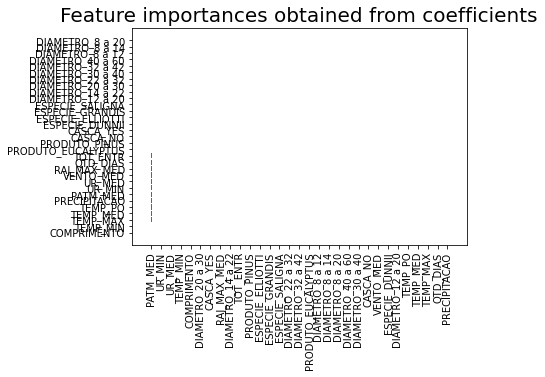

In [ ]:
# Calcule a importância das features
importance_rf = rf.feature_importances_
importance_lr = pandas.DataFrame(data={
                  'Attribute': dados_treino.columns,
                  'Importance': lr.coef_[0]
                })
importance_lr = importance_lr.sort_values(by='Importance', ascending=False)

#print(importance_rf)
#print(importance_lr)

# Crie um gráfico para visualizar a importância das features
matplot.barh(dados_teste.columns, importance_rf)

matplot.bar(x=importance_lr['Attribute'], height=importance_lr['Importance'], color='#087E8B')
matplot.title('Feature importances obtained from coefficients', size=20)
matplot.xticks(rotation='vertical')
matplot.show()

#matplot.xlabel('Importância da Feature')
#matplot.ylabel('Feature')
#matplot.title('Importância das Features no Modelo Random Forest')

# Mostre o gráfico
#matplot.show()

In [ ]:
#dfRegressao.head(10)

dados_treino, dados_teste, classe_treino, classe_teste = createDataPartition(dfRegressao, dfClassificacao['ESTORNO'], test_size=0.25)

In [ ]:
lasso = Lasso(alpha=1.0)

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:
scores = cross_val_score(lasso, dados_treino, classe_treino, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [ ]:
scores = absolute(scores)

In [ ]:
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: nan (nan)
